BERT for NER using BERTForTokenClassification 

In [1]:
import pandas as pd

annotations = pd.read_csv("./annotations.csv", index_col = ['id'])

In [2]:
annotations

,sentence#,token,tag,relabelled_tags
id,,,,
0,0,Om,CONCEPT,2
1,0,!,O,0
2,1,Having,O,0
3,1,bowed,O,0
4,1,down,O,0
...,...,...,...,...
830510,34331,The,O,0
830511,34331,end,O,0
830512,34331,of,O,0


In [3]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["token"].values.tolist(),
                                                           s["tag"].values.tolist(),
                                                           s["relabelled_tags"].values.tolist())]
        self.grouped = self.data.groupby("sentence#").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [4]:
getter = SentenceGetter(annotations)

In [5]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[3]

['Those',
 'ascetics',
 ',',
 'wishing',
 'to',
 'hear',
 'his',
 'wonderful',
 'narrations',
 ',',
 'presently',
 'began',
 'to',
 'address',
 'him',
 'who',
 'had',
 'thus',
 'arrived',
 'at',
 'that',
 'recluse',
 'abode',
 'of',
 'the',
 'inhabitants',
 'of',
 'the',
 'forest',
 'of',
 'Naimisha',
 '.']

In [6]:
def string_labels(l):
    if l == 0:
        return 'O'
    if l == 1:
        return 'Living'
    if l == 2:
        return 'Non-Living'
    return 'q'

In [7]:
labels = [[string_labels(s[2]) for s in sentence] for sentence in getter.sentences]
print(labels[1])

['O', 'O', 'O', 'O', 'Living', 'O', 'Living', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'Living', 'O', 'O', 'O', 'O', 'Non-Living', 'O', 'O', 'O']


In [8]:
tag_values = list(set(labels[1]))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [9]:
tag2idx

{'Non-Living': 0, 'O': 1, 'Living': 2, 'PAD': 3}

In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__


'1.9.0+cu102'

In [11]:
MAX_LEN = 75 # try with 512 also which is max
bs = 32

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [13]:
torch.cuda.get_device_name(1)

'Tesla V100-PCIE-16GB'

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [15]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        try:
            # Tokenize the word and count # of subwords the word is broken into
            if pd.isna(word):
                print("found nan")
                word = "null"
            tokenized_word = tokenizer.tokenize(word)
            n_subwords = len(tokenized_word)

            # Add the tokenized word to the final tokenized word list
            tokenized_sentence.extend(tokenized_word)

            # Add the same label to the new list of labels `n_subwords` times
            labels.extend([label] * n_subwords)
        except Exception as e:
            print(word)
            print(label)
            print(e)
            print(sentence)
            print(text_labels)
            print("------")
            return 
    return tokenized_sentence, labels

In [16]:
tokenized_texts_and_labels = [tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels)]

found nan
found nan


In [17]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [18]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [19]:
input_ids

array([[  152,  1306,   106, ...,     0,     0,     0],
       [ 5823, 11543,  1205, ...,     0,     0,     0],
       [  158, 14867,  1116, ...,  1104, 11896,  4060],
       ...,
       [ 1262,  1119,  1145, ...,     0,     0,     0],
       [ 1262,   117,   152, ...,     0,     0,     0],
       [ 1109,  1322,  1104, ...,     0,     0,     0]])

In [20]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [21]:
tags

array([[0, 0, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       [2, 2, 2, ..., 1, 0, 0],
       ...,
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3]])

In [22]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [23]:
train_i, test_i, train_tags, test_tags = train_test_split(input_ids, tags,
                                                            random_state=2021, test_size=0.2)
train_m, test_m, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2021, test_size=0.2)

In [24]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(train_i, train_tags,
                                                            random_state=2021, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(train_m, train_i,
                                             random_state=2021, test_size=0.2)

In [25]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [26]:
tr_inputs

tensor([[ 1124,  1110, 20869,  ...,     0,     0,     0],
        [10364,   117,  1119,  ...,  1104,  1134,  6131],
        [ 2091,  1343, 12200,  ...,     0,     0,     0],
        ...,
        [22179,  1343,  1734,  ...,     0,     0,     0],
        [ 1124,  1108,  3062,  ...,     0,     0,     0],
        [13832,  7877,  2913,  ...,     0,     0,     0]])

In [27]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [28]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__


'4.9.2'

In [29]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [30]:
model.cuda();


In [31]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [32]:
from transformers import get_linear_schedule_with_warmup

epochs = 10
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [33]:
from seqeval.metrics import f1_score, accuracy_score


In [34]:
from tqdm import trange
import numpy as np
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
    print()


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Average train loss: 0.030712737619817212
Validation loss: 0.010968128787956017
Validation Accuracy: 0.9967125312860682


/home/shreya15096/.conda/envs/virtualEnv/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Living seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/shreya15096/.conda/envs/virtualEnv/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Non-Living seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
Epoch:  10%|█         | 1/10 [01:51<16:44, 111.63s/it]

Validation F1-Score: 0.972952086553323

Average train loss: 0.007584807913231201
Validation loss: 0.01144658560630443
Validation Accuracy: 0.9965958164204848


Epoch:  20%|██        | 2/10 [03:43<14:54, 111.78s/it]

Validation F1-Score: 0.9724047306176083

Average train loss: 0.004071262090535884
Validation loss: 0.011462432772045865
Validation Accuracy: 0.9972831372955869


Epoch:  30%|███       | 3/10 [05:35<13:01, 111.69s/it]

Validation F1-Score: 0.9763172105222556

Average train loss: 0.0027025867116400207
Validation loss: 0.011941500304865892
Validation Accuracy: 0.9971729065892025


Epoch:  40%|████      | 4/10 [07:26<11:09, 111.50s/it]

Validation F1-Score: 0.9776782266162045

Average train loss: 0.0018675645313433607
Validation loss: 0.013447348291048572
Validation Accuracy: 0.9973868838427721


Epoch:  50%|█████     | 5/10 [09:17<09:16, 111.33s/it]

Validation F1-Score: 0.9787037037037037

Average train loss: 0.0008666834233230438
Validation loss: 0.015241978089209117
Validation Accuracy: 0.9974387571163648


Epoch:  60%|██████    | 6/10 [11:08<07:25, 111.43s/it]

Validation F1-Score: 0.979081435739097

Average train loss: 0.00066177605961045
Validation loss: 0.0178674124581131
Validation Accuracy: 0.9971988432259988


Epoch:  70%|███████   | 7/10 [13:03<05:37, 112.51s/it]

Validation F1-Score: 0.9760986892829606

Average train loss: 0.0004902002937801712
Validation loss: 0.01445275507949138
Validation Accuracy: 0.9976592185291333


Epoch:  80%|████████  | 8/10 [14:58<03:46, 113.26s/it]

Validation F1-Score: 0.9799475551442234

Average train loss: 0.00022085700242992307
Validation loss: 0.016685766403791307
Validation Accuracy: 0.9976267977331379


Epoch:  90%|█████████ | 9/10 [16:53<01:53, 113.68s/it]

Validation F1-Score: 0.9808435037849529

Average train loss: 0.00015271952048520978
Validation loss: 0.017149826372286594
Validation Accuracy: 0.9975749244595453


Epoch: 100%|██████████| 10/10 [18:47<00:00, 112.76s/it]

Validation F1-Score: 0.9790091063435714



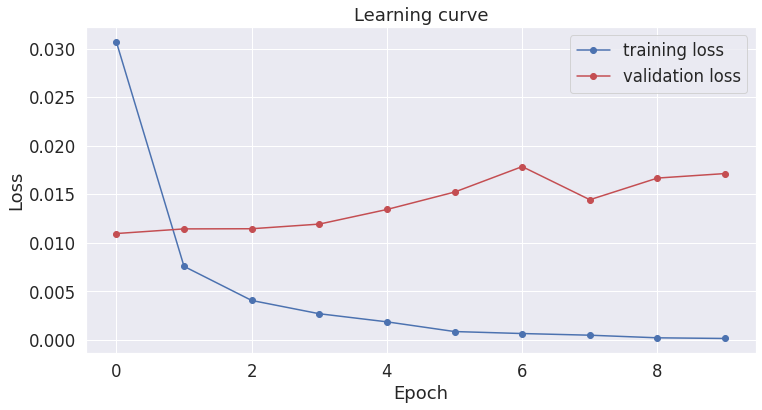

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [36]:
test = torch.tensor(test_i).cuda()
with torch.no_grad():
    output = model(test)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [37]:
label_indices

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 2, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [38]:
# join bpe split tokens
all_pred_labels = []
all_true_labels = []
all_tokens = []
for i in range(test.size()[0]):
    tokens = tokenizer.convert_ids_to_tokens(test.to('cpu').numpy()[i])
    new_tokens, new_labels, true_labels = [], [], []
    for token, label_idx, true_label_idx in zip(tokens, label_indices[i], test_tags[i]):
        if(token == '[PAD]'):
            continue
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)
            true_labels.append(tag_values[true_label_idx])
    all_pred_labels.append(new_labels)
    all_tokens.append(new_tokens)
    all_true_labels.append(true_labels)
#     for token, label, true_label in zip(new_tokens, new_labels, true_labels):
#         print("{}\t{}\t{}".format(label, token, true_label))


In [39]:
from seqeval.metrics import classification_report

In [40]:
print(classification_report(all_pred_labels, all_true_labels))

/home/shreya15096/.conda/envs/virtualEnv/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Living seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/shreya15096/.conda/envs/virtualEnv/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Non-Living seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

      Living       0.86      0.93      0.89      1033
       iving       0.99      0.98      0.99      7252

   micro avg       0.97      0.97      0.97      8285
   macro avg       0.93      0.96      0.94      8285
weighted avg       0.98      0.97      0.97      8285



In [40]:
i = 657
for token, pred, true in zip(all_tokens[i], all_pred_labels[i], all_true_labels[i]):
    print(token, pred, true)

" O O
Ashtaka Living Living
enquired O O
what O O
is O O
meant O O
by O O
Muni Living Living
. O O
' O O


In [41]:
len(all_tokens)

6867

In [42]:
test_sentence = '''Ganga dipped her feet in the holy Ganga. '''

In [43]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))


O	[CLS]
Living	Ganga
O	dipped
O	her
O	feet
O	in
O	the
O	holy
Non-Living	Ganga
O	.
O	[SEP]
